In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Sample problem

In [2]:
# Sample problem, Symmetric Positive Definite Matrix
A = np.array([[3,2],[2,6]])
b = np.array([2,-8])
c = 0

def quadratic_form(x, y, A,b,c):
    # Create the vector [x, y] and calculate the quadratic form
    vec = np.array([x, y])
    return 0.5*vec.T @ A @ vec - b.T @ vec + c

def gradient_quadratic_form(x,y,A):
    vec = np.array([x,y])
    return A @ vec


### Linear Equation 
$$ \mathbf{A} \vec{x} = \vec{b} $$ 

### Quadratic Form
$$ f(x) = \frac{1}{2} \vec{x}^T\mathbf{A}\vec{x} - \vec{b}^T\vec{x} + c$$

If $\mathbf{A}$ is PSD then $f(\vec{x})$ is paraboloid and it is minimized by the solution to $\mathbf{A}\vec{x}=\vec{b}$

### Gradients, Directions, 
$$ f'(x) = \frac{1}{2} A^Tx + \frac{1}{2} A x - b$$
If A is symmetric, then
$$f'(x) = Ax - b \quad \quad f(p) = f(x) + \frac{1}{2}(p-x)^T.A.(p-x)$$

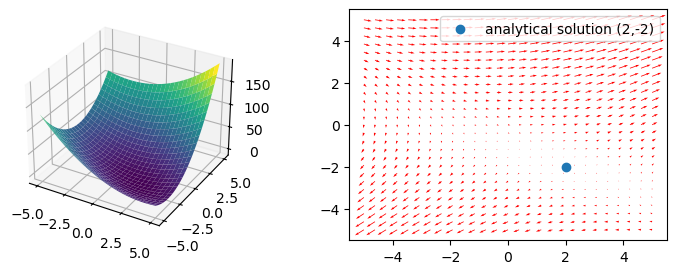

In [3]:
# generate a grid of points like [[x1,y1],[x2,y2],[x3,y3]] and evalue f at each point
x = np.linspace(-5,5,27)
y = np.linspace(-5,5,27)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = quadratic_form(X[i, j], Y[i, j], A,b,c)

# Gradients
dZdx,dZdy = np.gradient(Z,x,y)

fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax2 = fig.add_subplot(122)
ax2.quiver(X, Y, dZdx, dZdy, angles='xy', scale_units='xy', scale=100, color='r')
plt.scatter([2],[-2],label="analytical solution (2,-2)")
plt.legend()
plt.show()

## Conjugate Gradient

$$ \vec{u}^{(k+1)} = \vec{u}^{(k)} + \alpha^{(k)} \vec{d}^{(k)} $$
$$ \alpha^{(k)} = - \frac{\langle \vec{g}^{(k)} , \vec{d}^{(k)} \rangle}{\langle \vec{g}^{(k)},  \vec{d}^{(k)} \rangle_A} $$
$$ \vec{d}^{(k+1)} = - \vec{g}^{(k+1)} + \beta^{(k)} \vec{d}^{(k)}$$ 
$$ \beta^{(k)} = - \frac{\langle \vec{g}^{(k+1)} , \vec{d}^{(k)} \rangle_A}{\langle \vec{d}^{(k)},  \vec{d}^{(k)} \rangle_A} $$

- $\vec{d}$ is the direction for the next step
- $\vec{g}$ is the gradient of the bowl
- $\beta$ is a memory of the previous direction
- $\vec{d}^{(0)} = - \vec{g}^{(0)} = \vec{f} - \mathbf{A}\vec{u}^{(0)}$

## CG applied to 1-D poisson

In [4]:
def poisson_matrix_1D(N):
    # generate N-2 X N-2 matrix of interior points 
    h = 1.0 / (N - 1)
    main_diag = 2.0 * np.ones(N - 2)
    off_diag = -1.0 * np.ones(N - 3)
    A = (1.0 / h**2) * (
        np.diag(main_diag) +
        np.diag(off_diag, k=1) +
        np.diag(off_diag, k=-1)
    )
    return A

def conjugate_gradient(A, b, tolerance = 1e-10, max_iter = 100):
    u_arr = [] # all iterations of solution
    r_arr = [] # all iterations of residue-norm

    # initialize the 0th iteration of u,g,d
    u = np.zeros_like(b) # initial guess 
    g = A @ u - b # initial gradient
    d = -g.copy() # initial direction
    res = np.sqrt(np.dot(g,g)) # initial residue-norm

    for k in range(max_iter):
        Ad = A @ d
        dAd = d @ Ad
        
        alpha = -(g @ d)/dAd # (k)th iteration of step-size 
        u = u + alpha * d # (k+1)th iteration of solution
        g = g + alpha * Ad # (k+1)th iteration of gradient 
        beta = (g @ Ad)/dAd # (k)th iteration of beta
        d = -g + beta*d # (k+1)th iteration of direction
        r = np.sqrt(g @ g) # (k+1)th iteration of residue-norm
        u_arr.append(u) 
        r_arr.append(r) 
        if(r < tolerance):
            print(f"Converged after {k} iterations. Residue Norm = {r}")
            break;
    return (np.array(u_arr),np.array(r_arr))

Converged after 17 iterations. Residue Norm = 1.6999047554928061e-15


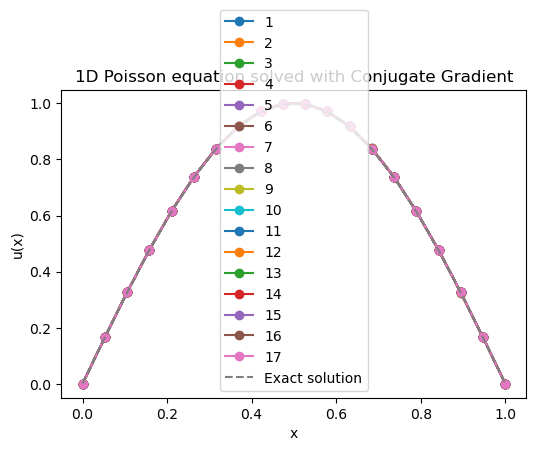

In [5]:
# Iteration Parameters
N = 20
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
A = poisson_matrix_1D(N)
b = (np.pi**2) * np.sin(np.pi * x[1:-1]) # evaluate b at interior points only
b = b + np.random.randn(N-2)/1000 # add some noise to b
u_exact = np.sin(np.pi * x) # exact solution

fig = plt.figure(figsize=(6,4))

# Solve with CG and apply DBC
u_arr,r_arr = conjugate_gradient(A, b)
for k in range(1,len(u_arr)):
    u = np.zeros_like(x)
    u[1:-1] = u_arr[k]
    plt.plot(x, u, 'o-', label=f'{k}')

# plt.plot(x, u, 'o-', label='CG solution')
plt.plot(x, u_exact, '--', label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('1D Poisson equation solved with Conjugate Gradient')
plt.show()

## Apply CG to 2D Poisson 


In [136]:

def AnalyticalSolution(N):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    return np.sin(np.pi * X) * np.sin(np.pi * Y)

def AnalyticalLaplacian(N):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    return 2 * (np.pi**2) * np.sin(np.pi * X) * np.sin(np.pi * Y)


In [137]:
# Compute the 5-point stencil laplacian 
# AU = -(U[i+1, j] + U[i-1, j] + U[i, j+1] + U[i, j-1] - 4*U[i, j]) / h**2
# This will be applied to kth iteration of u to compute the kth iteration of gradient g = Au - f
# This will be applied to the kth iteration of d to compute alpha, beta 
# Assume Dirichlet Boundary Conditions 
def LaplacianOperator(X):
    N = X.shape[0]
    h = 1/(N-1)
    h2 = h**2
    AX = X.copy()
    
    for i in range(1,N-1):
        for j in range(1,N-1):
            left    = X[i-1,j]
            right   = X[i+1,j]
            up      = X[i,j-1]
            down    = X[i,j+1]
            centre  = X[i,j]
            AX[i,j] = -(left + right + up + down - 4*centre)/h2
    
    return AX

In [138]:

def conjugate_gradient_2D_poisson(f, max_iter = 200):
    u = np.zeros_like(f)
    g = LaplacianOperator(u) - f
    d = -g.copy()
    res = []

    for k in range(max_iter):
        Ad = LaplacianOperator(d)
        dAd = np.sum(d * Ad)
        # dAd = np.linalg.norm(d.T @ Ad)
        
        # alpha = -(g @ d)/(d @ LaplacianOperator(d))
        alpha = -np.sum(g*d)/dAd 
        
        u = u + alpha * d
        g = g + alpha * LaplacianOperator(d)

        r = np.sum(g*g)
        res.append(r)
        
        # beta = ( g @ LaplacianOperator(d) )/( d @ LaplacianOperator(d) )
        beta = np.sum(g*d)/(np.sum(d * LaplacianOperator(d)))
        
        d = -g + beta*d
    return u,res

|U_exact - U_num|: 0.0004281423247561677
Residue Norm: 1.902066347686376e-27


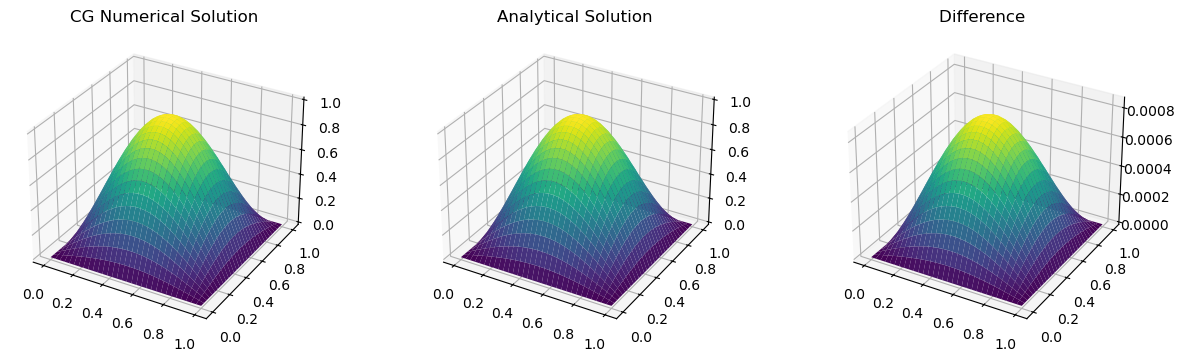

In [155]:

N = 32
U_exact = AnalyticalSolution(N)

F = AnalyticalLaplacian(N)
# F = LaplacianOperator(U_exact)

U_num,res = conjugate_gradient_2D_poisson(F)

# plot
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
X, Y = np.meshgrid(x, y, indexing='ij')

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, U_num, cmap='viridis')
ax1.set_title("CG Numerical Solution")

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, U_exact, cmap='viridis')
ax2.set_title("Analytical Solution")

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, np.abs(U_exact-U_num), cmap='viridis')
ax3.set_title("Difference ")


# compare
h = 1.0/(N-1)
err = np.sqrt(np.sum((U_num - U_exact)**2) * h**2)
print("|U_exact - U_num|:", err)
print("Residue Norm:", res[-1])

plt.show()
